# 1 - Imports

In [4]:
# native packages
import os, logging, warnings, json, functools, time

# some setup
warnings.filterwarnings('ignore', module='tqdm.auto')  # deprication warnings
warnings.filterwarnings('ignore', module='sklearn.neural_network._multilayer_perceptron')  # convergence warnings
logger = logging.getLogger(__name__)

# other packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import pointbiserialr

# custom package
import sl_utils

# sklearn imports
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
)
from sklearn.neighbors import ( 
    KNeighborsRegressor, 
    KNeighborsClassifier
)
from sklearn.neural_network import (
    MLPRegressor,
    MLPClassifier
)
from sklearn.feature_selection import (
    mutual_info_classif, 
    SelectKBest
)


# 2 - Setup

## 2.1 - Utility Functions and Globals

In [5]:
# download data from kaggle and set up loader - global
DATA = sl_utils.SL_Report_Data()
DATA.set_up_data()

# experiment directory - global
EXPERIMENT_NAME = 'expr2'  # global var
if not os.path.exists(DATA.root+f'logs/{EXPERIMENT_NAME}/'):
    os.mkdir(DATA.root+f'logs/{EXPERIMENT_NAME}/')

def optimize_and_log(opt_params, log_filename):
    opt_name = log_filename.replace('.json', '')
    if not os.path.exists(f'{DATA.root}logs/{EXPERIMENT_NAME}/{log_filename}'):
        with sl_utils.Gridsearch_Optimization(**opt_params) as opt:
            print(f'Optimizing {opt_name}')
            opt.find_best_params(log_as=f'{DATA.root}logs/{EXPERIMENT_NAME}/{log_filename}')
            print('Best Model:', opt.best_result)
            opt.plot_validation_and_complexity_curves(opt_name)
    else:
        with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/{log_filename}', 'r') as file:
            results = json.load(file)
        with sl_utils.Gridsearch_Optimization(**opt_params) as opt:
            opt.results = results
            del results  # avoid memory bloat, results can be big
            if opt_params['want_low']:
                opt.best_result = sorted(opt.results, key=lambda cv_results: cv_results['test_score'])[0]
            else:
                opt.best_result = sorted(opt.results, key=lambda cv_results: cv_results['test_score'])[-1]
            print('Best Model:', opt.best_result)
            opt.plot_validation_and_complexity_curves(opt_name)
    return

def depth_and_width_to_layer_sizes(depths, width_reductions, n_features):
    hidden_layer_sizes = []
    for n in n_features:
        for d in depths:
            for wr in width_reductions:
                layer_prog = [round(n*wr)]
                for layer in range(d-1):
                    if layer_prog[-1]*wr < 1:
                        break
                    layer_prog.append(round(layer_prog[-1]*wr))
                hidden_layer_sizes.append(tuple(layer_prog))
    hidden_layer_sizes = list(set(hidden_layer_sizes))
    return hidden_layer_sizes

def data_size_metrics(model, metric, X, y, results_json, stratify=None, want_low=True):
    log_as = DATA.root+'logs/'+EXPERIMENT_NAME+'/'+results_json.split('.')[0]+'_by_size.json'
    sizes = np.linspace(0.1, 0.9, 15)
    if stratify is not None: 
        stratify = y
    else:
        stratify = None
    if not os.path.exists(log_as):
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            random_state=7,
            train_size=0.9,
            shuffle=True,
            stratify=stratify
        )
        with open(DATA.root+'logs/'+EXPERIMENT_NAME+'/'+results_json, 'r') as file:
            results = json.load(file)
        if want_low:
            best_params = sorted(results, key=lambda cv_result: cv_result['test_score'])[0]['params']
        else:
            best_params = sorted(results, key=lambda cv_result: cv_result['test_score'])[-1]['params']
        model = model(**best_params)
        size_results = []
        for perc in tqdm(sizes):
            t0 = time.time()
            n = int(X_train.shape[0]*perc)
            model.fit(X_train.head(n), y_train.head(n))
            t1 = time.time()
            preds = model.predict(X_train.head(n))
            t2 = time.time()
            size_results.append({
                'percent': perc,
                'test_error': metric(y_test, model.predict(X_test)),
                'train_error': metric(y_train.head(n), preds),
                'train_time': t1-t0,
                'predict_time': t2-t1
            })
        with open(log_as, 'w+') as file:
            json.dump(size_results, file)
    else:
        with open(log_as, 'r') as file:
            size_results = json.load(file)
    plt.plot(sizes*X.shape[0], [r['train_error'] for r in size_results], 'o-', color='blue', label='Train Error')
    plt.plot(sizes*X.shape[0], [r['test_error'] for r in size_results], 'o-', color='orange', label='Test Error')
    plt.legend()
    plt.xlabel('Training Data Size')
    plt.ylabel(' '.join(metric.__name__.split('_')).title())
    plt.title(results_json.split('.')[0]+' Learning Curve')
    plt.show()
    plt.plot(sizes*X.shape[0], [r['train_time'] for r in size_results], 'o-', color='blue', label='Train Time')
    plt.plot(sizes*X.shape[0], [r['predict_time'] for r in size_results], 'o-', color='orange', label='Predict Time')
    plt.legend()
    plt.xlabel('Training Data Size')
    plt.ylabel('Time (Seconds)')
    plt.title(results_json.split('.')[0]+' Learning Curve')
    plt.show()
    return

def best_feature_names(metric, X, y, k):
    dimred = SelectKBest(score_func=metric, k=k)
    dimred.fit(X, y)
    return dimred.get_feature_names_out()

def clean_cancer_data(raw_cancer_df):
    meta = ['Year', 'Patient_ID']
    targets = ['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']
    categoricals = ['Gender', 'Country_Region', 'Cancer_Type', 'Cancer_Stage']

    # drop outputs and patient IDs
    cancer_inputs = pd.get_dummies(
        raw_cancer_df.drop(meta+targets, axis=1),
        columns = categoricals,
        drop_first = True
        ).astype(int)
    
    # return
    return cancer_inputs

Already have Cancer Dataset
Cancer Demo Saved
Already Have Bankruptcy Dataset
Bankruptcy Demo Saved


## 2.2 - Preprocess Data

In [6]:
###############################################
# cancer
###############################################

print('Processing Cancer Data.')

# cancer data setup
cancer_inputs = clean_cancer_data(DATA.get_cancer_full())
target_severity = DATA.get_cancer_full()['Target_Severity_Score']

# only use rows with notable correlation
cancer_corrs = cancer_inputs.corrwith(target_severity)
cancer_best_cols = []
print('Best Columns:')
for i, score in enumerate(cancer_corrs):
    if abs(score) >= 0.2:
        cancer_best_cols.append(cancer_inputs.columns[i])
        print(len(cancer_best_cols), '\t', cancer_inputs.columns[i], '\t', round(score, 2))
cancer_inputs = cancer_inputs[cancer_best_cols]

# robust scaler to hopefully improve runtime
cols = cancer_inputs.columns
cancer_inputs = pd.DataFrame(RobustScaler().fit_transform(cancer_inputs), columns=cols)

# get test set outside of CV data
print('Dataset is far too large to train on over many iterations. We are just finding best params anyway.')
cancer_train, cancer_test, target_train, target_test = train_test_split(
    cancer_inputs,
    target_severity,
    shuffle=True,
    random_state=7,
    train_size=0.25,  # training very expensive on large set, only fitting hyperparams
    test_size=0.25
    )

print(f'Reduced to fitting on {cancer_train.shape[0]} rows for tractability!')

print('Done.')
print()

###############################################
# bankruptcy
###############################################

print('Processing Bankruptcy Data.')

bankruptcy_data = DATA.get_bankruptcy_full()

# robust scaler to hopefully improve runtime
financial_data = bankruptcy_data.drop('Bankrupt?', axis=1)
cols = financial_data.columns
financial_data = pd.DataFrame(RobustScaler().fit_transform(financial_data), columns=cols)

# dimensionality reduction
nominated = best_feature_names(functools.partial(mutual_info_classif, random_state=7), financial_data, bankruptcy_data['Bankrupt?'], financial_data.shape[1]//10)

# only use correlated cols
bankruptcy_best_cols = []
print('Best Columns:')
for i, col in enumerate(nominated):
    corr = pointbiserialr(bankruptcy_data['Bankrupt?'], financial_data[col])[0]
    if abs(corr) >= 0.2:
        bankruptcy_best_cols.append(col)
        print(len(bankruptcy_best_cols), '\t', col, '\t', round(corr, 2))
financial_data = financial_data[bankruptcy_best_cols]

print(\
    f'Only {round(
        100*bankruptcy_data[bankruptcy_data['Bankrupt?']==1].shape[0]/bankruptcy_data.shape[0]
        ,2
    )}% of the data is reflects bankrupted companies! Massive class imbalance.'\
)

# only use so many non-bankrupt samples to more closely "balance" the dataset
bankruptcy0 = financial_data[bankruptcy_data['Bankrupt?']==0]
bankruptcy1 = financial_data[bankruptcy_data['Bankrupt?']==1]
train_indices = bankruptcy0.sample(bankruptcy1.shape[0]*3).index
financial_data = pd.concat([bankruptcy0.loc[train_indices], bankruptcy1])
bankruptcy_data = pd.concat([bankruptcy_data.loc[train_indices], bankruptcy_data[bankruptcy_data['Bankrupt?']==1]])

# free up memory
del bankruptcy0
del bankruptcy1

print(\
    f'Eliminated class 0 samples until {round(
        100*bankruptcy_data[bankruptcy_data['Bankrupt?']==1].shape[0]/bankruptcy_data.shape[0]
        ,2
    )}% of the data is reflects bankrupted companies. Down to {bankruptcy_data.shape[0]} rows.'\
)

financial_train, financial_test, bankrupt_train, bankrupt_test = train_test_split(
    financial_data,
    bankruptcy_data['Bankrupt?'],
    shuffle=True,
    random_state=7,
    test_size=0.1,  # just a little bit, we want most for CV,
    stratify=bankruptcy_data['Bankrupt?']  # split evenly by class
    )

# add discarded data to test set
financial_test = pd.concat([DATA.get_bankruptcy_full()[bankruptcy_best_cols].drop(train_indices, axis=0), financial_test])
bankrupt_test = pd.concat([DATA.get_bankruptcy_full()['Bankrupt?'].drop(train_indices, axis=0), bankrupt_test])
print(f'Discarded data added to test set, {financial_test.shape[0]} rows. Fitting with {financial_train.shape[0]} rows.')

print('Done.')


Processing Cancer Data.
Best Columns:
1 	 Genetic_Risk 	 0.48
2 	 Air_Pollution 	 0.37
3 	 Alcohol_Use 	 0.36
4 	 Smoking 	 0.48
5 	 Obesity_Level 	 0.25
Dataset is far too large to train on over many iterations. We are just finding best params anyway.
Reduced to fitting on 12500 rows for tractability!
Done.

Processing Bankruptcy Data.
Best Columns:
1 	  ROA(A) before interest and % after tax 	 -0.28
2 	  Persistent EPS in the Last Four Seasons 	 -0.22
3 	  Per Share Net profit before tax (Yuan ¥) 	 -0.2
4 	  Debt ratio % 	 0.25
5 	  Net profit before tax/Paid-in capital 	 -0.21
6 	  Net Income to Total Assets 	 -0.32
Only 3.23% of the data is reflects bankrupted companies! Massive class imbalance.
Eliminated class 0 samples until 25.0% of the data is reflects bankrupted companies. Down to 880 rows.
Discarded data added to test set, 6247 rows. Fitting with 792 rows.
Done.


## 2.4 - Tasks

- find best model by CV scores [X]
  - mse for cancer
  - f1 for bankruptcy 
- show validation curves [X]
  - take best models, then see what happens when individual params change a bit
- show performance by data amounts [X]
- perform feature selection []
  - sklearn SelectFromModel
  - sklearn RFE
  - sklearn SelectKBest
  - sklearn SelectPercentile

# 4 - Cancer

## 4.1 - SVM

Best Model: {'fit_time': 0.1805274486541748, 'score_time': 0.011726776758829752, 'test_score': 0.3103181300323383, 'train_score': 0.31024299799008037, 'index': 66, 'params': {'C': 10.0, 'degree': 1, 'epsilon': 1.0, 'kernel': 'poly'}, 'holdout_score': 0.3125263427719742}


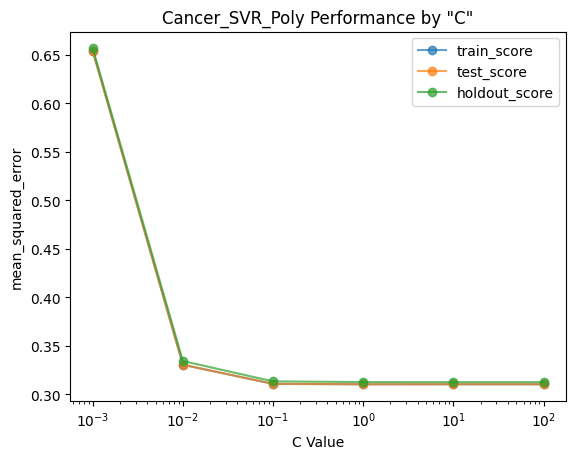

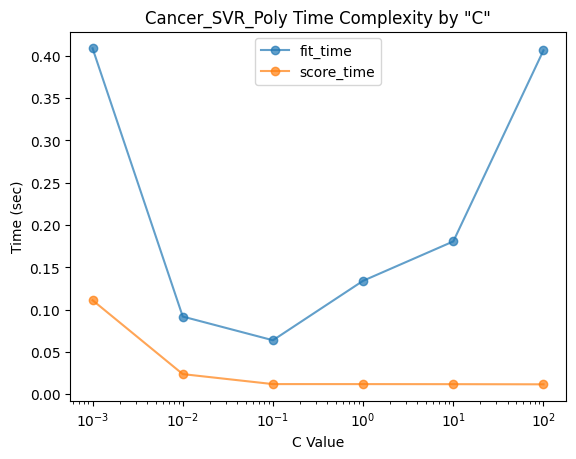

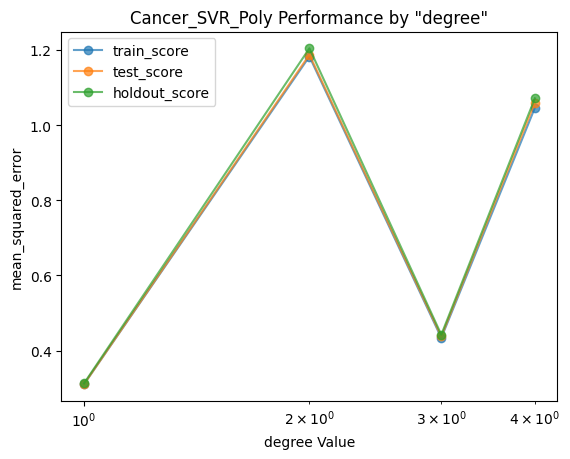

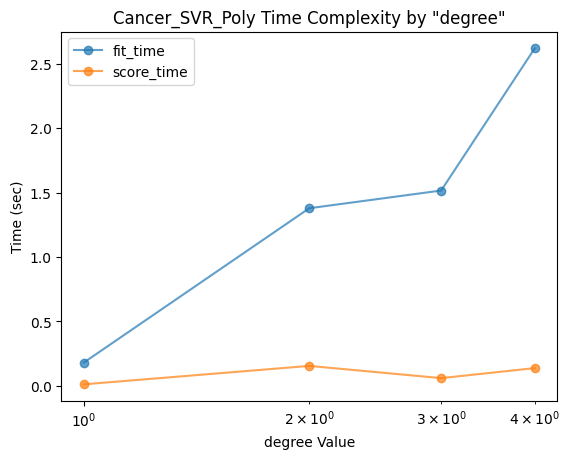

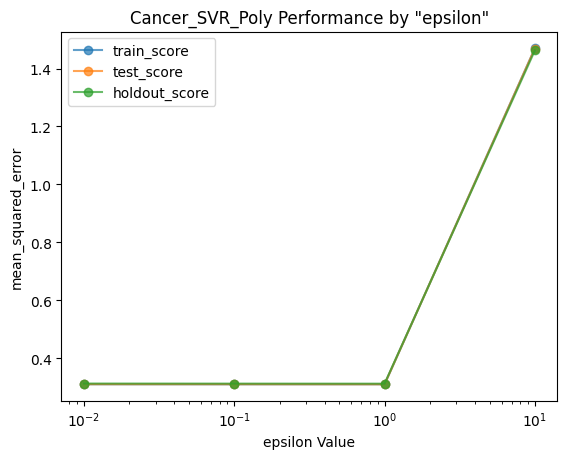

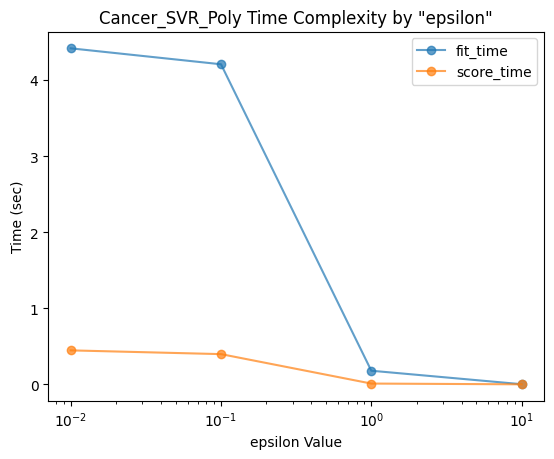

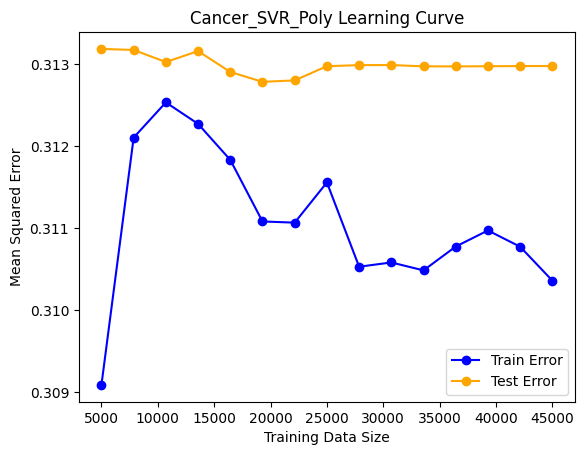

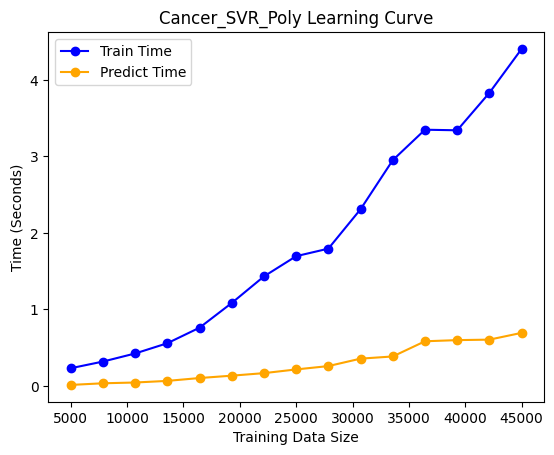

Best Model: {'fit_time': 0.2856515248616536, 'score_time': 0.08280634880065918, 'test_score': 0.310331147209657, 'train_score': 0.31017600541415113, 'index': 110, 'params': {'C': 100.0, 'epsilon': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}, 'holdout_score': 0.312982288530002}


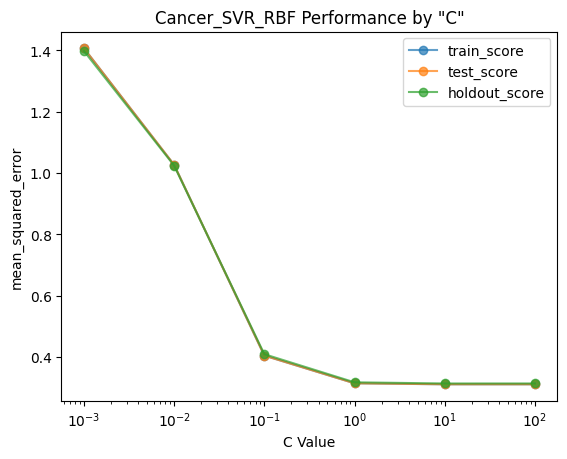

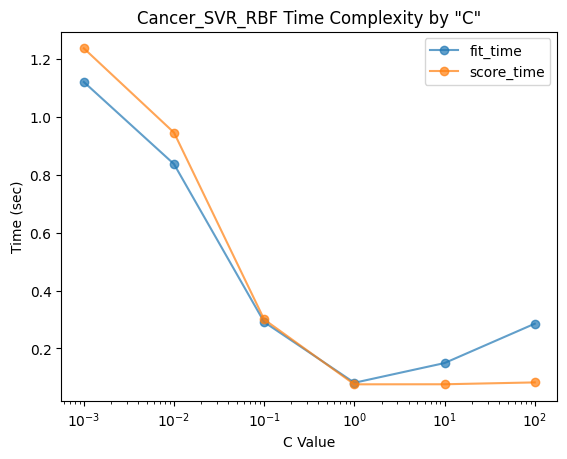

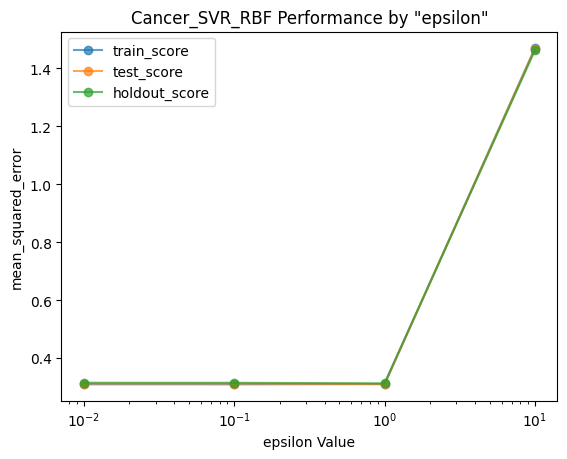

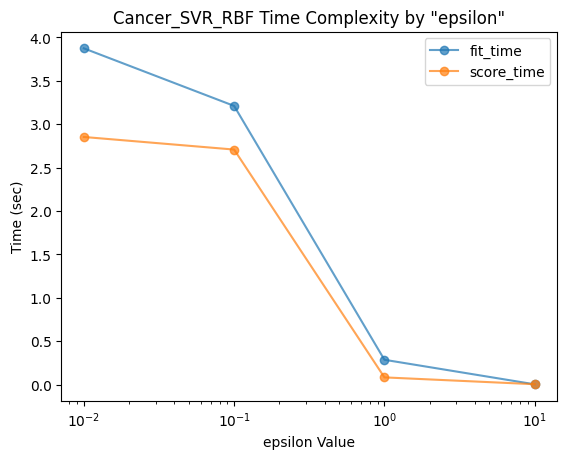

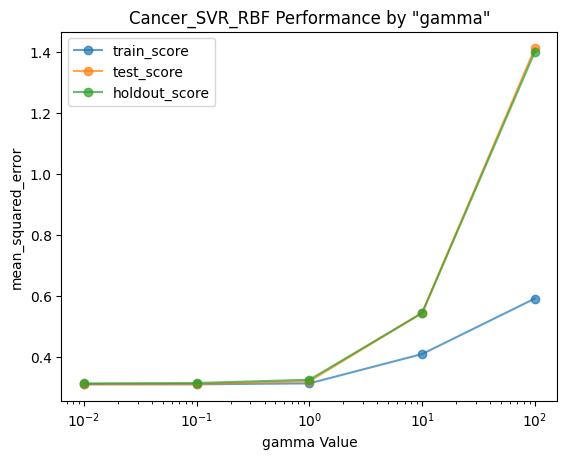

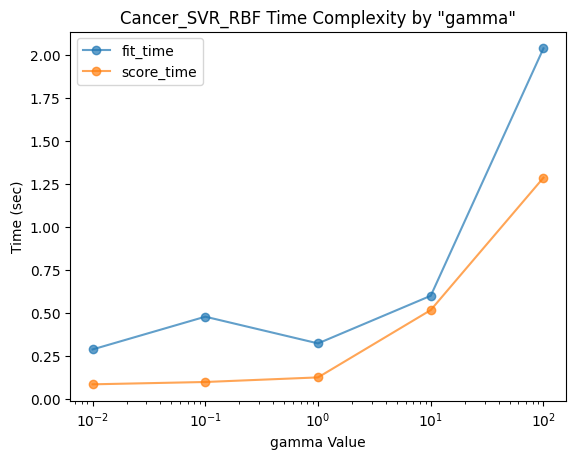

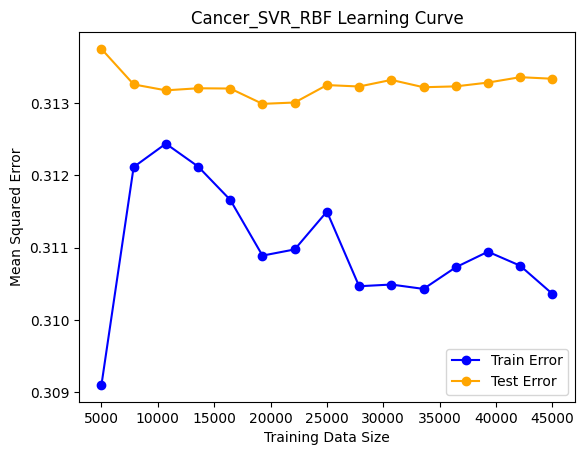

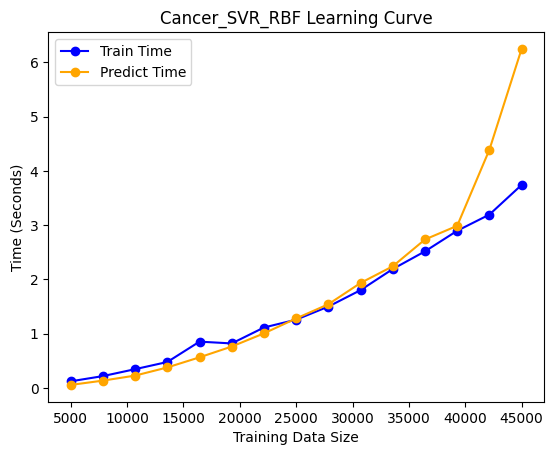

In [7]:
###############################################
# polynomial svr
###############################################

cancer_poly_grid = {
    'C': np.logspace(-3, 2, num=6, base=10),
    'degree': [int(d) for d in np.linspace(1, 4, 4)],
    'epsilon': np.logspace(-2, 1, num=4, base=10),
    'kernel': 'poly'
    }

cancer_poly_expr = {
    'rangedict': cancer_poly_grid,
    'estimator': svm.SVR,
    'metric': 'neg_mean_squared_error',
    'invert_metric': True,
    'X': cancer_train,
    'y': target_train,
    'holdout_X': cancer_test,
    'holdout_y': target_test,
    'holdout_metric': mean_squared_error,
    'want_low': True
}

optimize_and_log(cancer_poly_expr, 'Cancer_SVR_Poly.json')
data_size_metrics(
    svm.SVR, 
    mean_squared_error, 
    cancer_inputs, 
    target_severity, 
    'Cancer_SVR_Poly.json', 
    stratify=None, 
    want_low=True
)

###############################################
# rbf svr
###############################################

cancer_rbf_grid = {
    'C': np.logspace(-3, 2, num=6, base=10),
    'epsilon': np.logspace(-2, 1, num=4, base=10),
    'gamma': np.logspace(-2, 2, base=10, num=5),
    'kernel': 'rbf'
    }

cancer_rbf_expr = {
    'rangedict': cancer_rbf_grid,
    'estimator': svm.SVR,
    'metric': 'neg_mean_squared_error',
    'invert_metric': True,
    'X': cancer_train,
    'y': target_train,
    'holdout_X': cancer_test,
    'holdout_y': target_test,
    'holdout_metric': mean_squared_error,
    'want_low': True
}

optimize_and_log(cancer_rbf_expr, 'Cancer_SVR_RBF.json')
data_size_metrics(
    svm.SVR, 
    mean_squared_error, 
    cancer_inputs, 
    target_severity, 
    'Cancer_SVR_RBF.json', 
    stratify=None, 
    want_low=True
)

## 4.2 - KNN

Best Model: {'fit_time': 0.009179035822550455, 'score_time': 0.46116193135579425, 'test_score': 0.33659833736541717, 'train_score': 0.32044430472075286, 'index': 106, 'params': {'n_neighbors': 40, 'p': 4, 'weights': 'uniform'}, 'holdout_score': 0.3386324962716667}


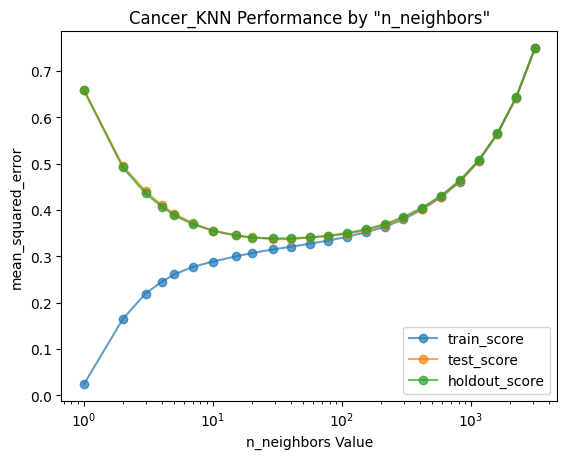

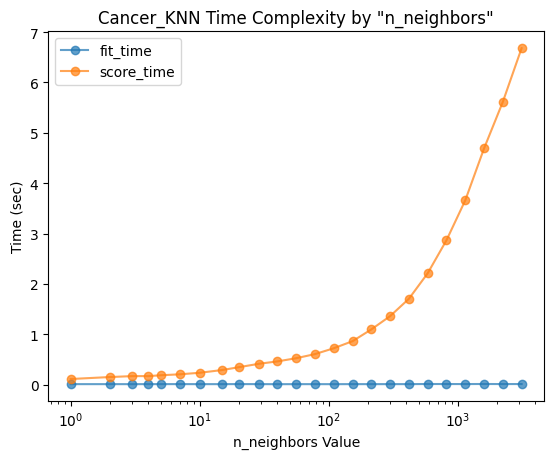

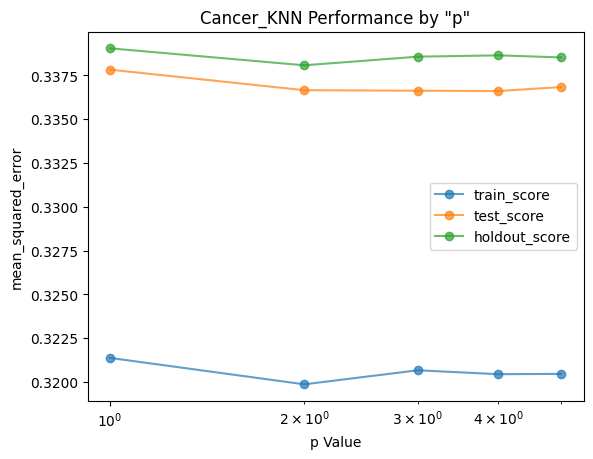

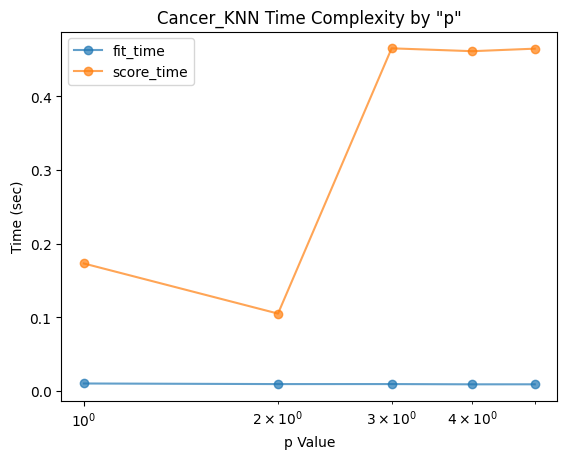

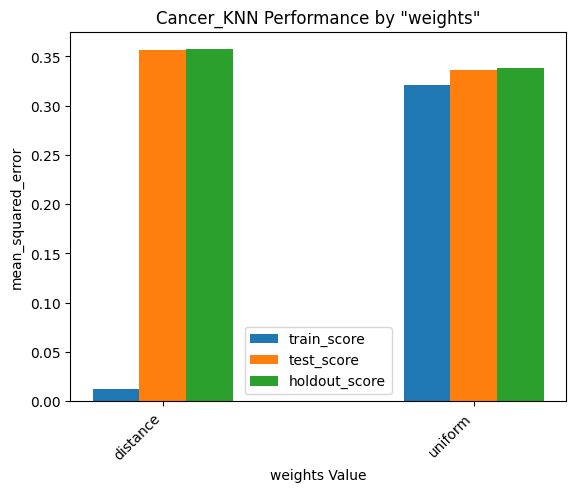

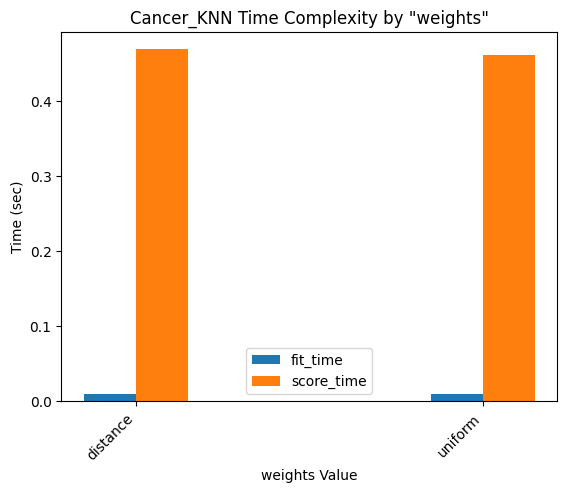

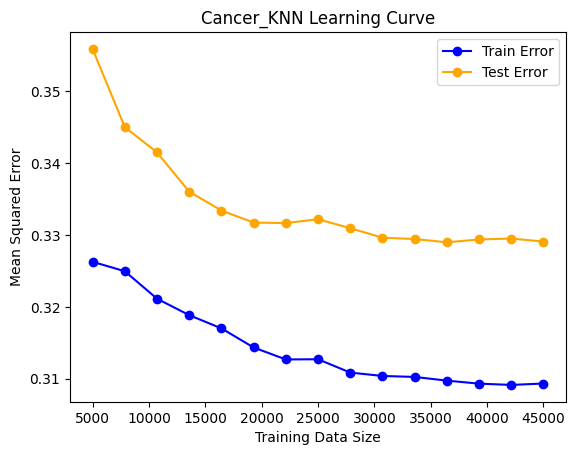

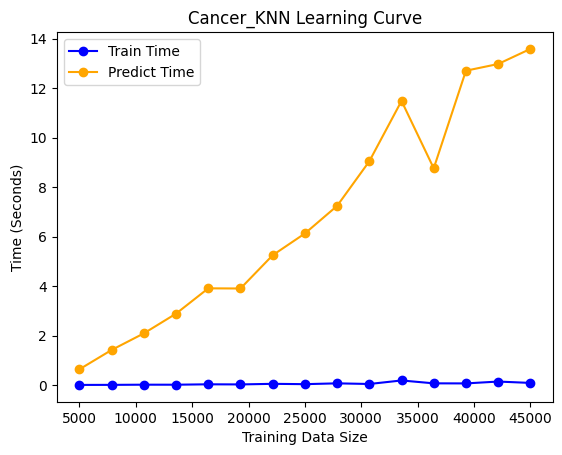

In [8]:
###############################################
# knn 
###############################################

cancer_knn_grid = {
    'n_neighbors': sorted(list(set([round(k) for k in np.logspace(0, np.log2(cancer_train.shape[0]//4), num=25, base=2)]))),
    'weights': ['uniform', 'distance'],
    'p': list(range(1,6))  # assume minkowski default (1: manhattan, 2: euclidean, 3+:...)
    }

cancer_knn_expr = {
    'rangedict': cancer_knn_grid,
    'estimator': KNeighborsRegressor,
    'metric': 'neg_mean_squared_error',
    'invert_metric': True,
    'X': cancer_train,
    'y': target_train,
    'holdout_X': cancer_test,
    'holdout_y': target_test,
    'holdout_metric': mean_squared_error,
    'want_low': True
}

optimize_and_log(cancer_knn_expr, 'Cancer_KNN.json')
data_size_metrics(
    KNeighborsRegressor, 
    mean_squared_error, 
    cancer_inputs, 
    target_severity, 
    'Cancer_KNN.json', 
    stratify=None, 
    want_low=True
)

## 4.3 - NN

Best Model: {'fit_time': 1.6375614802042644, 'score_time': 0.0013377666473388672, 'test_score': 0.3102172401534235, 'train_score': 0.3101881133175812, 'index': 794, 'params': {'activation': 'relu', 'alpha': 1.0, 'hidden_layer_sizes': [10], 'max_iter': 400, 'solver': 'adam'}, 'holdout_score': 0.3128010945996131}


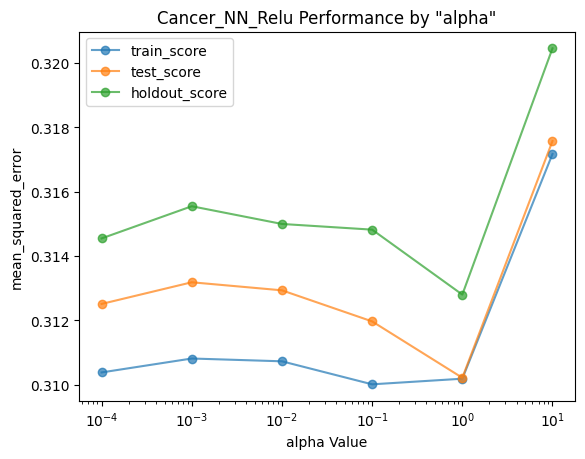

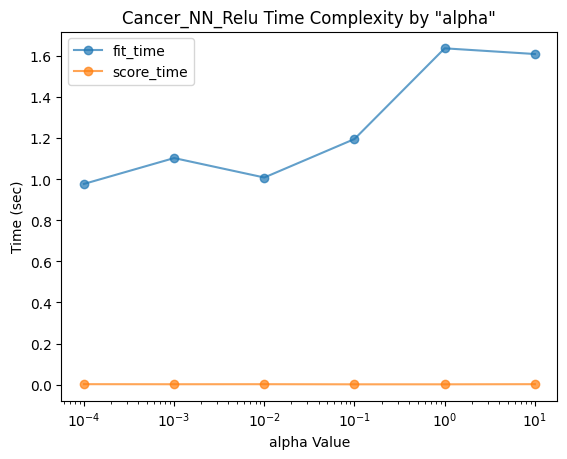

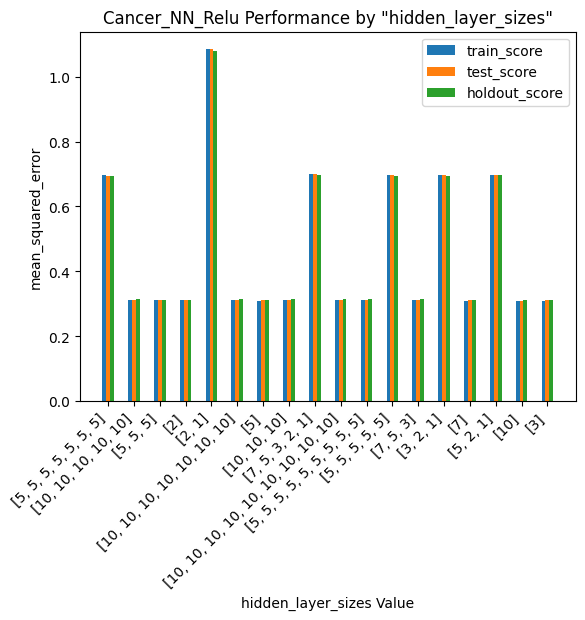

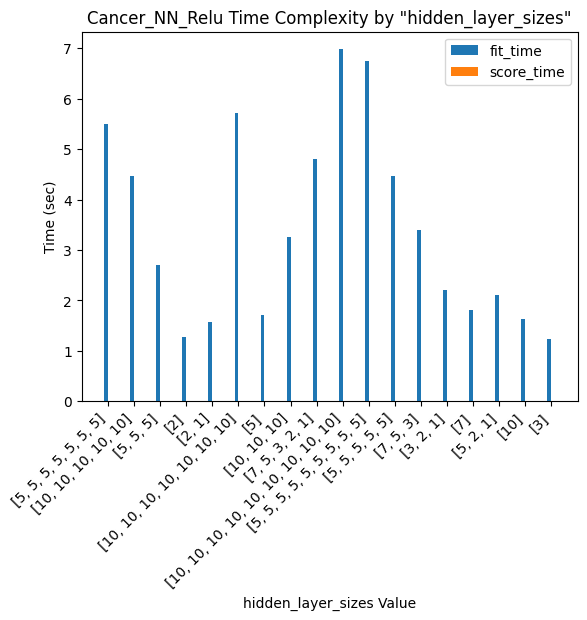

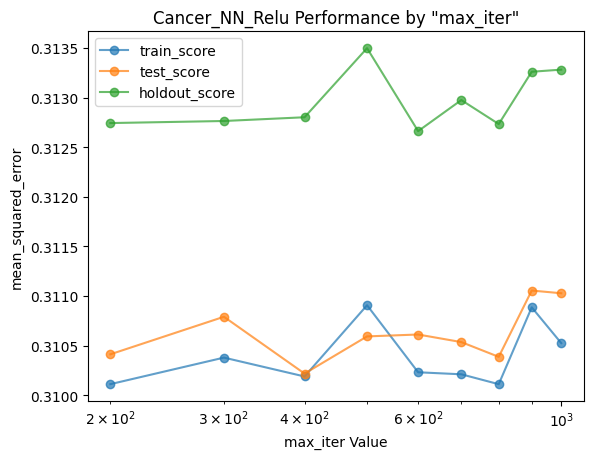

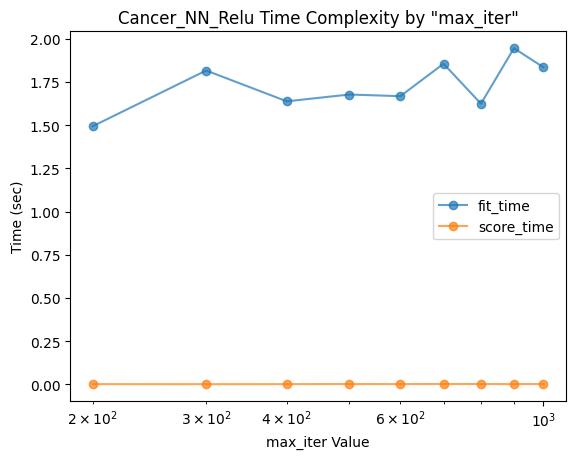

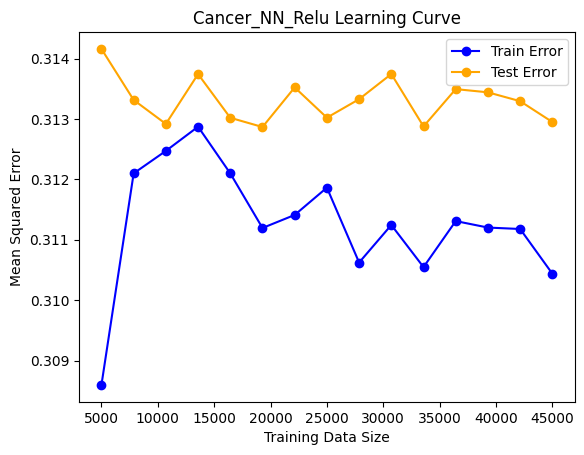

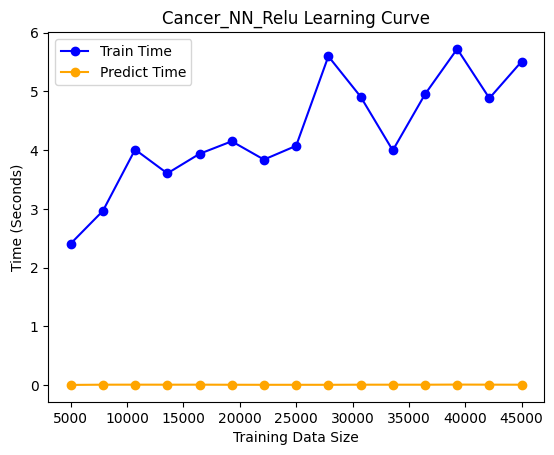

Best Model: {'fit_time': 5.144350131352742, 'score_time': 0.007833719253540039, 'test_score': 0.3141678764710892, 'train_score': 0.31325153356060786, 'index': 25, 'params': {'activation': 'logistic', 'alpha': 1e-05, 'hidden_layer_sizes': [10, 10, 10], 'solver': 'adam'}, 'holdout_score': 0.3177048593988834}


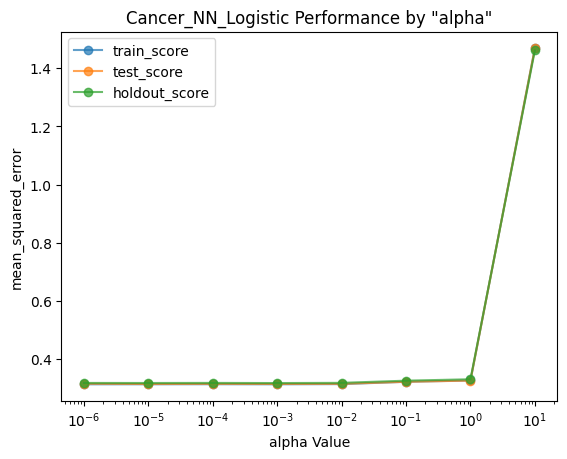

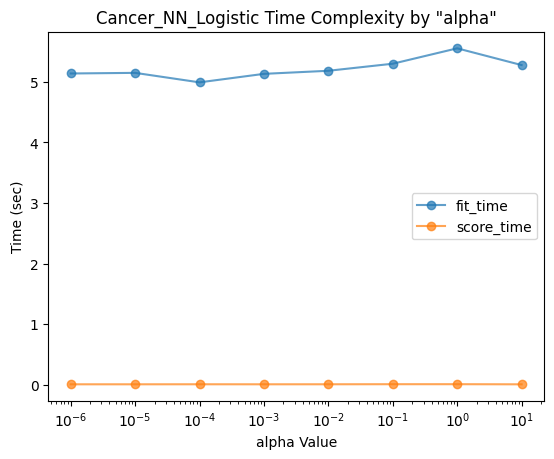

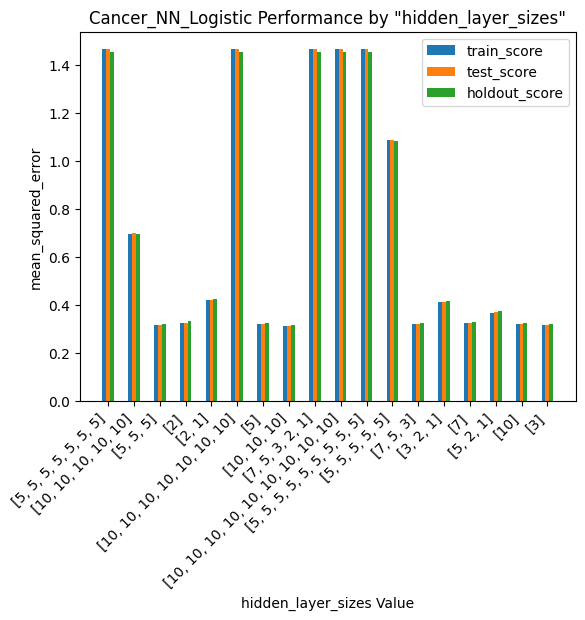

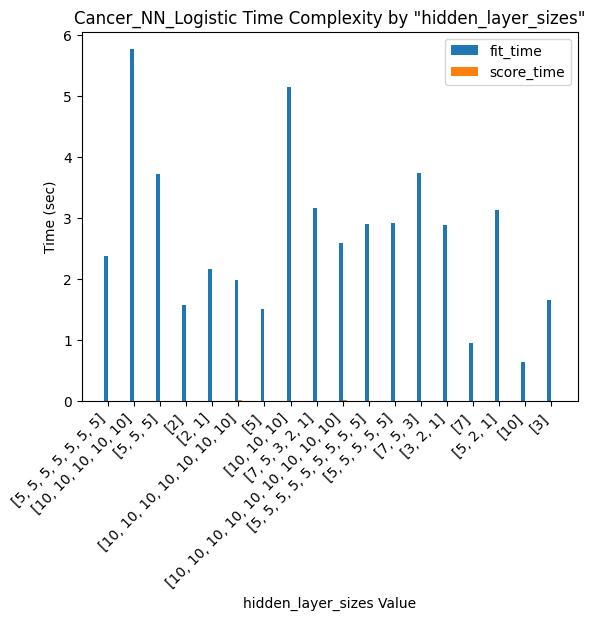

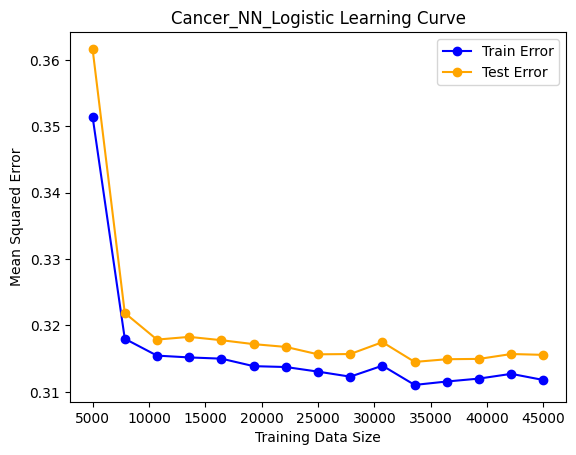

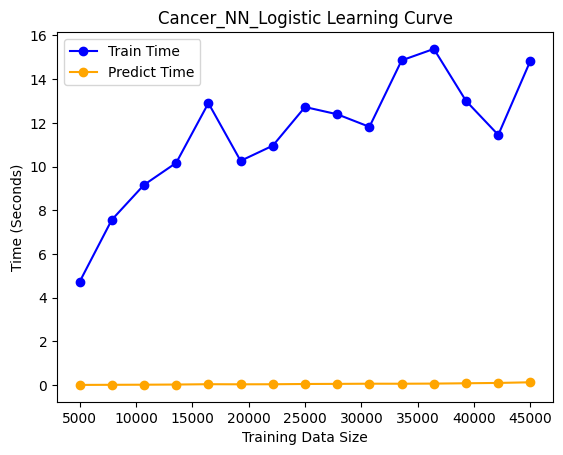

In [9]:
###############################################
# relu nn
###############################################

n_hidden_layers = range(1, 10, 2)  # 1-9, odds
layer_size_changes = [1, 2/3, 1/2]
hidden_layer_sizes = depth_and_width_to_layer_sizes(n_hidden_layers, layer_size_changes, [cancer_train.shape[1], cancer_train.shape[1]*2])

cancer_relu_grid = {
    'activation': 'relu',
    'solver': 'adam',
    'alpha': np.logspace(-4, 1, base=10, num=6),
    'hidden_layer_sizes': hidden_layer_sizes,
    'max_iter': range(200, 1001, 100)
}

cancer_relu_expr = {
    'rangedict': cancer_relu_grid,
    'estimator': MLPRegressor,
    'metric': 'neg_mean_squared_error',
    'invert_metric': True,
    'X': cancer_train,
    'y': target_train,
    'holdout_X': cancer_test,
    'holdout_y': target_test,
    'holdout_metric': mean_squared_error,
    'want_low': True
}

optimize_and_log(cancer_relu_expr, 'Cancer_NN_Relu.json')
data_size_metrics(
    MLPRegressor, 
    mean_squared_error, 
    cancer_inputs, 
    target_severity, 
    'Cancer_NN_Relu.json', 
    stratify=None, 
    want_low=True
)

###############################################
# logistic nn
###############################################

cancer_logistic_grid = {
    'activation': 'logistic',
    'solver': 'adam',
    'alpha': np.logspace(-6, 1, base=10, num=8),
    'hidden_layer_sizes': hidden_layer_sizes
}

cancer_logistic_expr = {
    'rangedict': cancer_logistic_grid,
    'estimator': MLPRegressor,
    'metric': 'neg_mean_squared_error',
    'invert_metric': True,
    'X': cancer_train,
    'y': target_train,
    'holdout_X': cancer_test,
    'holdout_y': target_test,
    'holdout_metric': mean_squared_error,
    'want_low': True
}

optimize_and_log(cancer_logistic_expr, 'Cancer_NN_Logistic.json')
data_size_metrics(
    MLPRegressor, 
    mean_squared_error, 
    cancer_inputs, 
    target_severity, 
    'Cancer_NN_Logistic.json', 
    stratify=None, 
    want_low=True
)

# 5. Bankruptcy

## 5.1 - SVM

Best Model: {'fit_time': 0.00552829106648763, 'score_time': 0.005453904469807942, 'test_score': 0.7570095117865817, 'train_score': 0.7541986169943159, 'index': 30, 'params': {'C': 1.0, 'class_weight': 'balanced', 'degree': 1, 'kernel': 'poly'}, 'holdout_score': 0.12892477999060167}


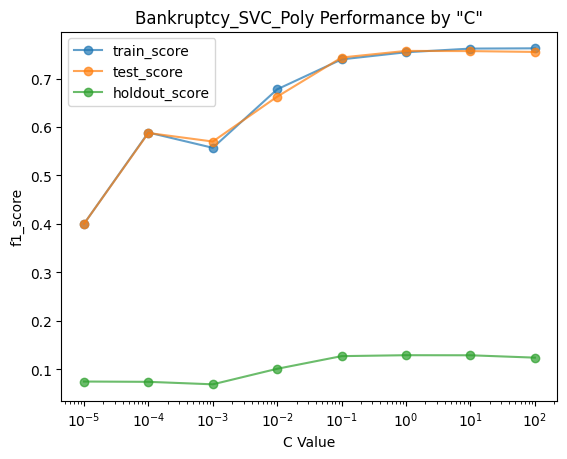

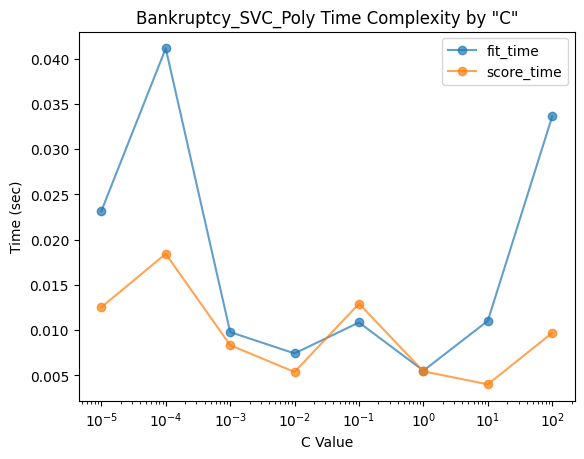

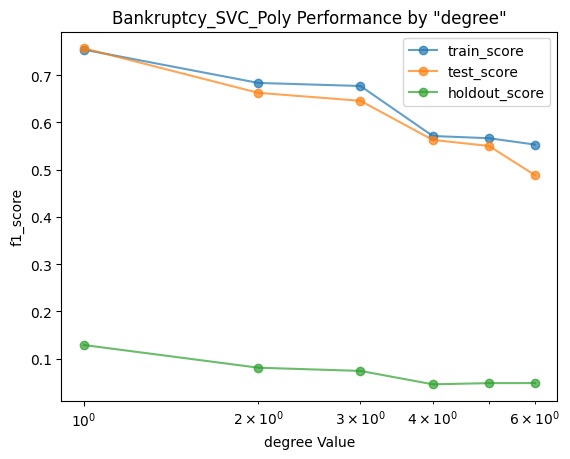

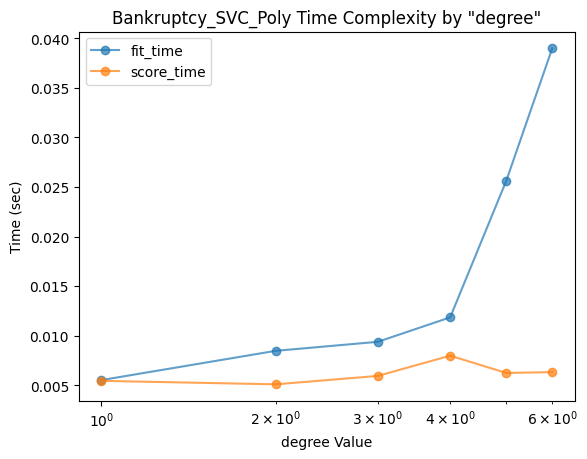

100%|██████████| 15/15 [00:06<00:00,  2.25it/s]


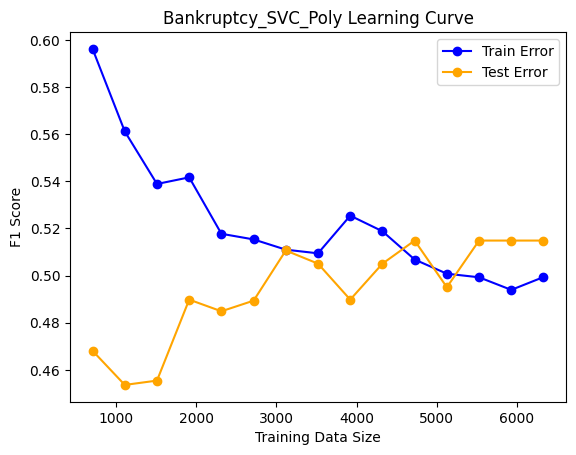

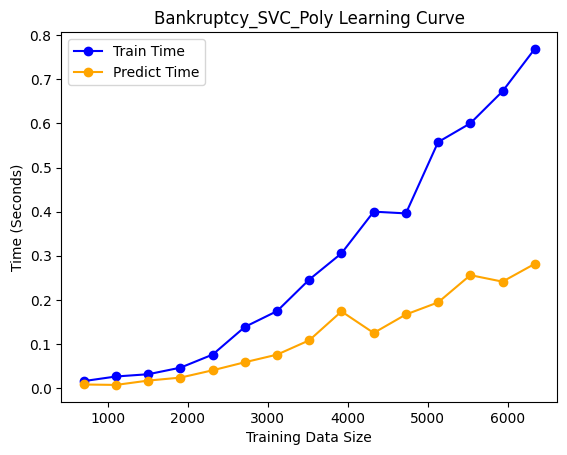

Best Model: {'fit_time': 0.007698535919189453, 'score_time': 0.009373029073079428, 'test_score': 0.7737220995830268, 'train_score': 0.7753843691980936, 'index': 36, 'params': {'C': 10.0, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}, 'holdout_score': 0.12965223489078773}


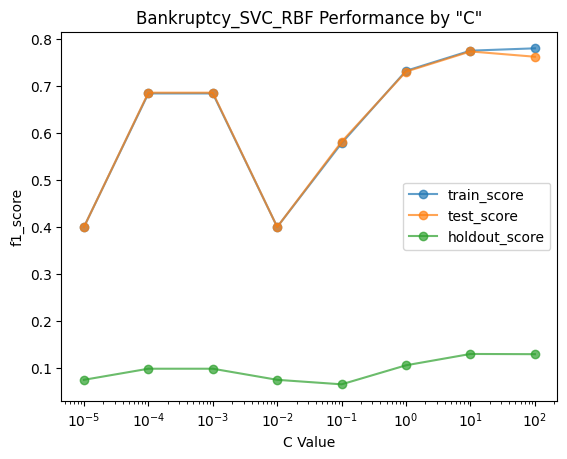

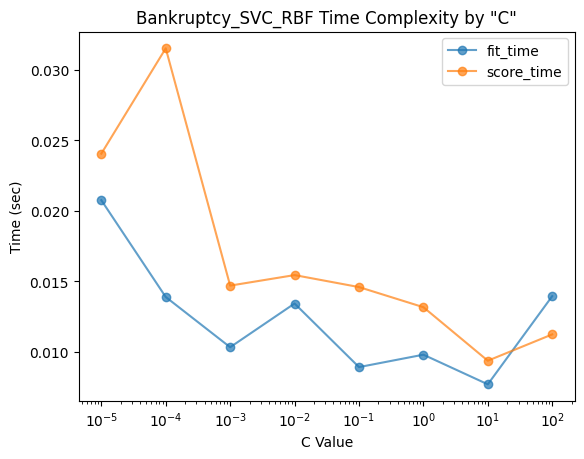

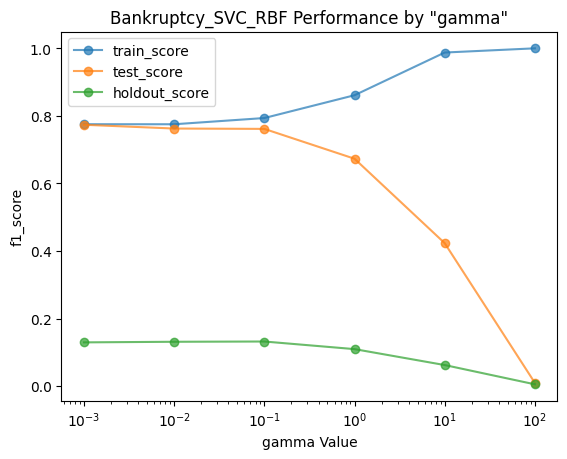

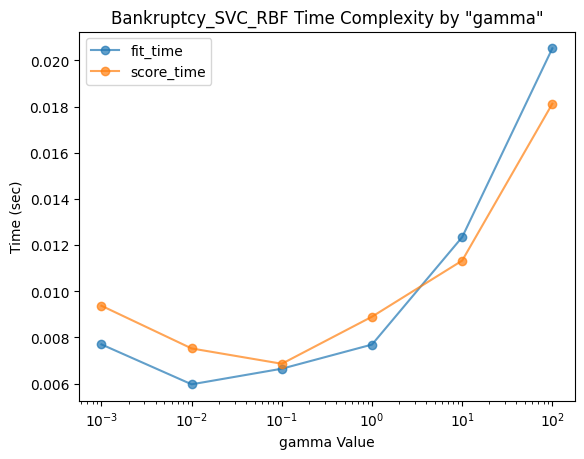

100%|██████████| 15/15 [00:16<00:00,  1.09s/it]


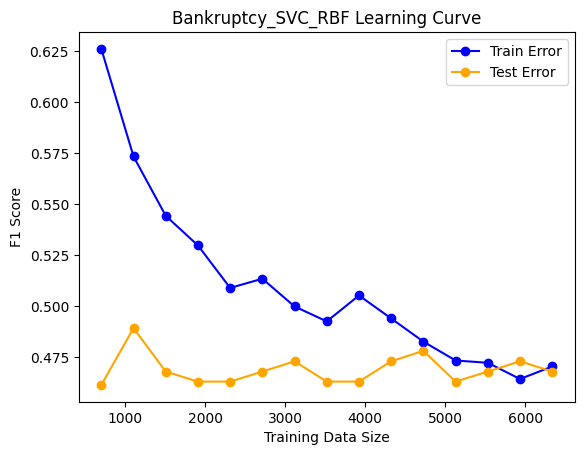

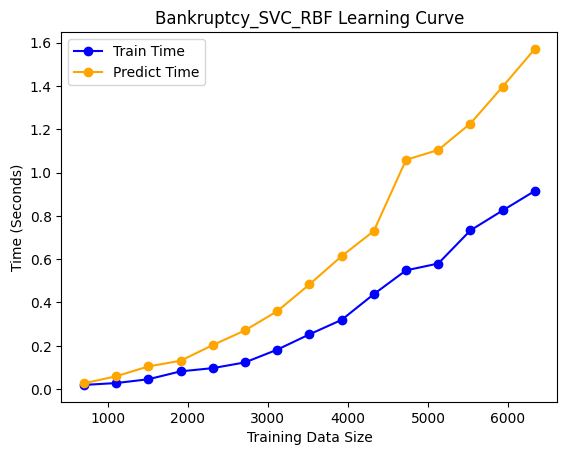

In [ ]:
###############################################
# polynomial svc
###############################################

bankruptcy_poly_grid = {
    'C': np.logspace(-5, 2, num=8, base=10),
    'degree': [int(d) for d in np.linspace(1, 6, 6)],
    'kernel': 'poly', 
    'class_weight': 'balanced'
    }

bankruptcy_poly_expr = {
    'rangedict': bankruptcy_poly_grid,
    'estimator': svm.SVC,
    'metric': 'f1',
    'X': financial_train,
    'y': bankrupt_train,
    'holdout_X': financial_test,
    'holdout_y': bankrupt_test,
    'holdout_metric': f1_score,
    'want_low': False
}

optimize_and_log(bankruptcy_poly_expr, 'Bankruptcy_SVC_Poly.json')
data_size_metrics(
    svm.SVC, 
    f1_score, 
    pd.concat([financial_train, financial_test]).sample(frac=1, random_state=7), 
    pd.concat([bankrupt_train, bankrupt_test]).sample(frac=1, random_state=7), 
    'Bankruptcy_SVC_Poly.json', 
    stratify=True, 
    want_low=False
)

###############################################
# rbf svc
###############################################

bankruptcy_rbf_grid = {
    'C': np.logspace(-5, 2, num=8, base=10),
    'gamma': np.logspace(-3, 2, base=10, num=6),
    'kernel': 'rbf',
    'class_weight': 'balanced'
    }

bankruptcy_rbf_expr = {
    'rangedict': bankruptcy_rbf_grid,
    'estimator': svm.SVC,
    'metric': 'f1',
    'X': financial_train,
    'y': bankrupt_train,
    'holdout_X': financial_test,
    'holdout_y': bankrupt_test,
    'holdout_metric': f1_score,
    'want_low': False
}

optimize_and_log(bankruptcy_rbf_expr, 'Bankruptcy_SVC_RBF.json')
data_size_metrics(
    svm.SVC, 
    f1_score, 
    pd.concat([financial_train, financial_test]).sample(frac=1, random_state=7), 
    pd.concat([bankrupt_train, bankrupt_test]).sample(frac=1, random_state=7), 
    'Bankruptcy_SVC_RBF.json', 
    stratify=True, 
    want_low=False
)

## 5.2 - KNN

Best Model: {'fit_time': 0.0026677449544270835, 'score_time': 0.018452882766723633, 'test_score': 0.7626984126984127, 'train_score': 0.7787914642753352, 'index': 122, 'params': {'n_neighbors': 27, 'p': 2, 'weights': 'uniform'}, 'holdout_score': 0.10763073552650988}


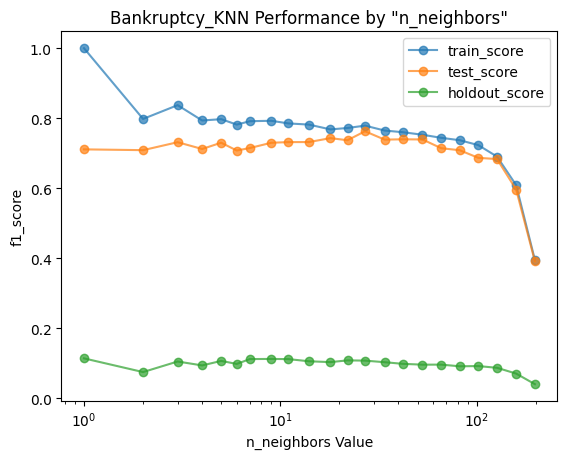

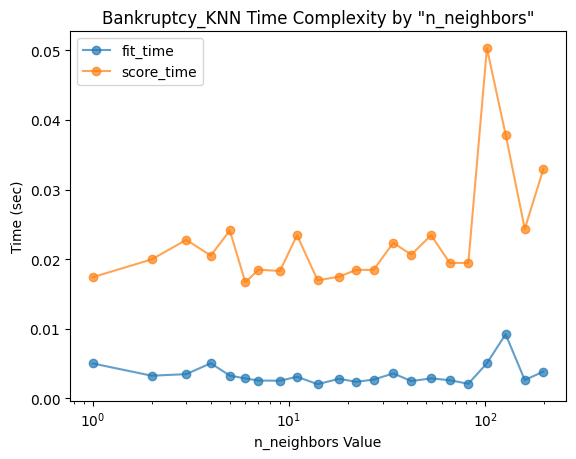

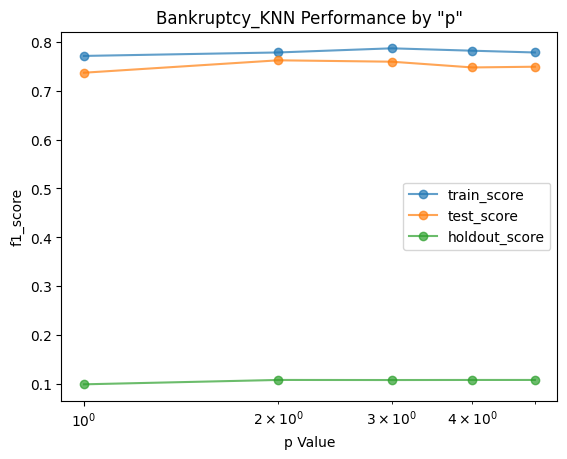

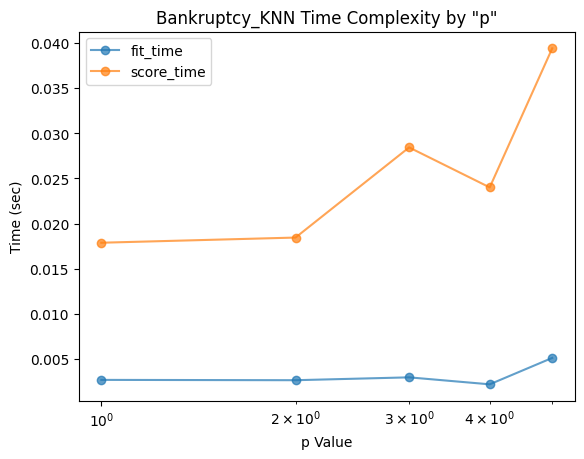

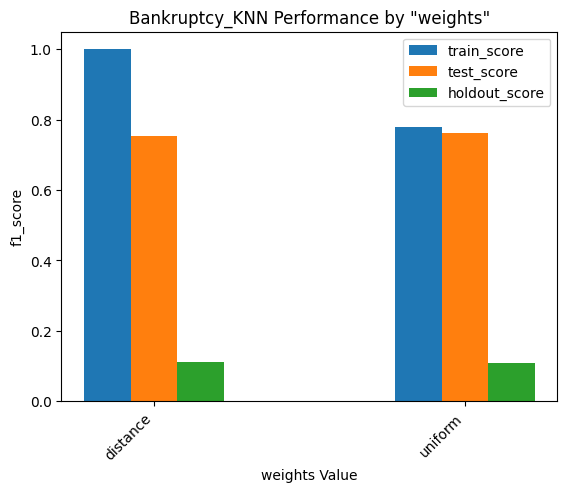

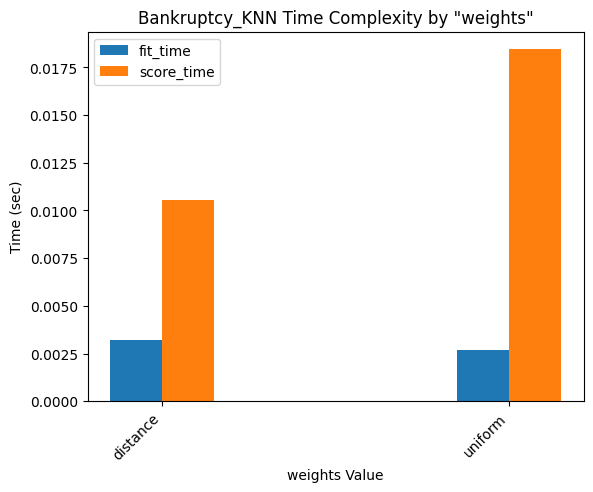

100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


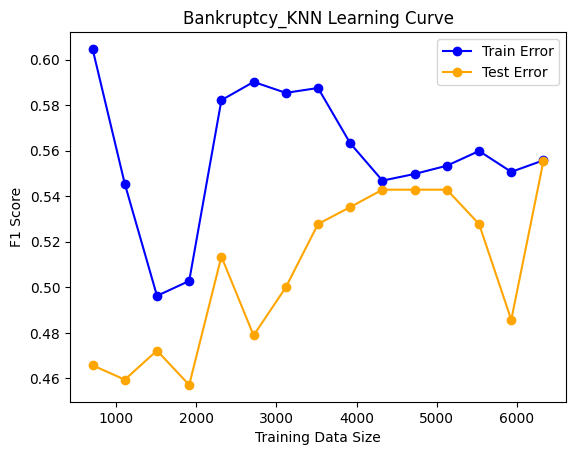

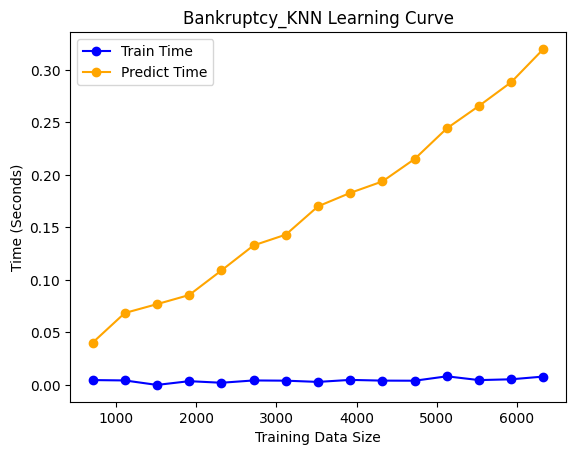

In [ ]:
###############################################
# knn
###############################################

bankruptcy_knn_grid = {
    'n_neighbors': sorted(list(set([round(k) for k in np.logspace(0, np.log2(financial_train.shape[0]//4), num=25, base=2)]))),
    'weights': ['uniform', 'distance'],
    'p': list(range(1,6))  # assume minkowski default (1: manhattan, 2: euclidean, 3+:...)
    }

bankruptcy_knn_expr = {
    'rangedict': bankruptcy_knn_grid,
    'estimator': KNeighborsClassifier,
    'metric': 'f1',
    'X': financial_train,
    'y': bankrupt_train,
    'holdout_X': financial_test,
    'holdout_y': bankrupt_test,
    'holdout_metric': f1_score,
    'want_low': False
}

optimize_and_log(bankruptcy_knn_expr, 'Bankruptcy_KNN.json')
data_size_metrics(
    KNeighborsClassifier, 
    f1_score, 
    pd.concat([financial_train, financial_test]).sample(frac=1, random_state=7), 
    pd.concat([bankrupt_train, bankrupt_test]).sample(frac=1, random_state=7), 
    'Bankruptcy_KNN.json', 
    stratify=True, 
    want_low=False
)

## 5.3 - NN

Best Model: {'fit_time': 0.3155078887939453, 'score_time': 0.0034040609995524087, 'test_score': 0.7990384615384616, 'train_score': 0.7858469774771898, 'index': 201, 'params': {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': [8], 'max_iter': 500, 'solver': 'adam'}, 'holdout_score': 0.11277363077682191}


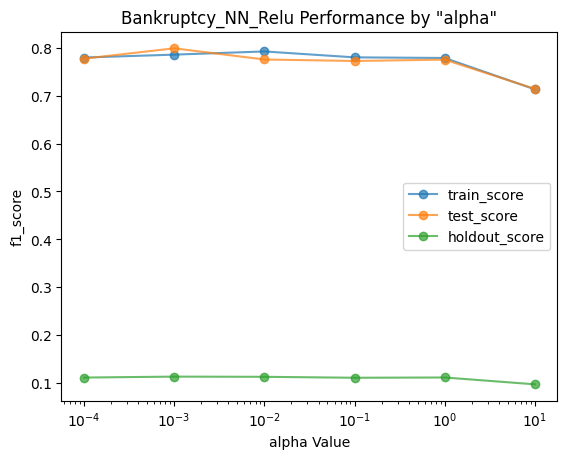

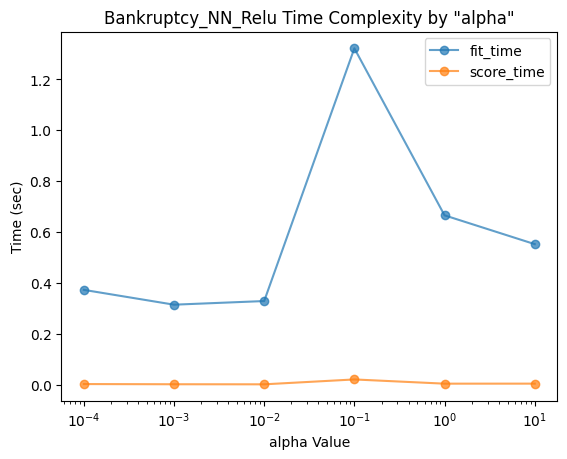

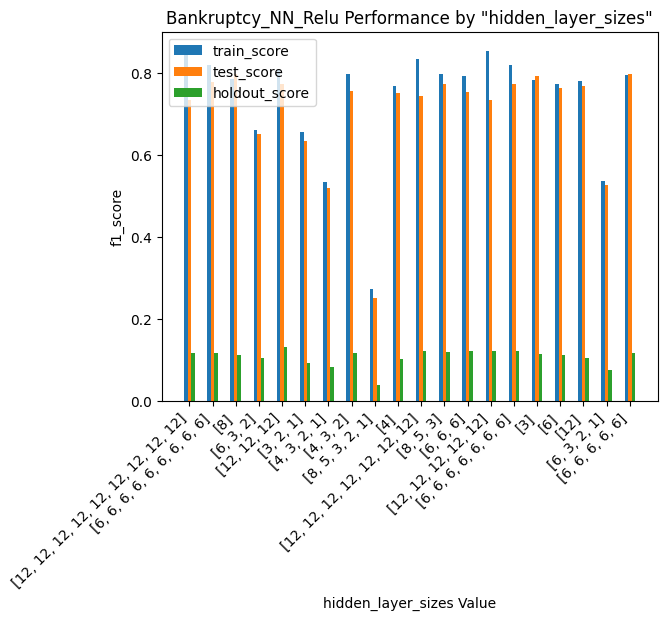

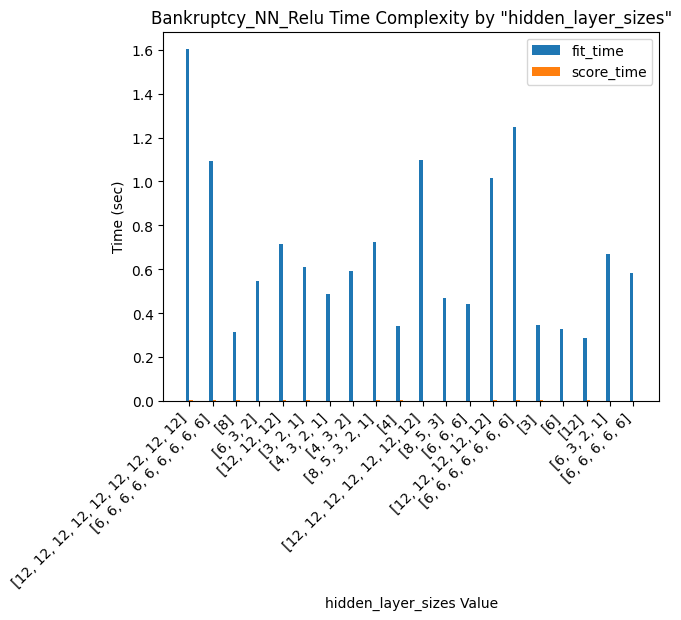

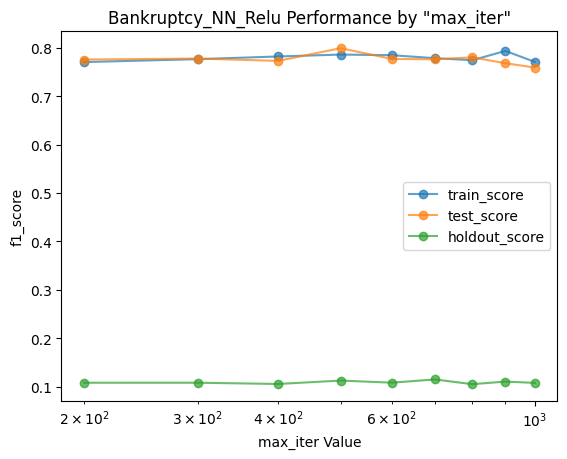

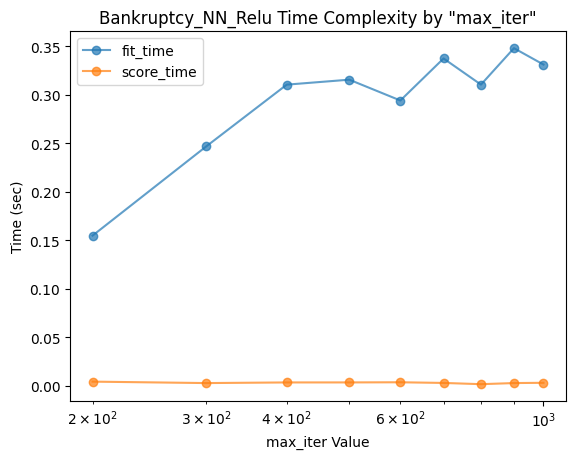

100%|██████████| 15/15 [00:18<00:00,  1.22s/it]


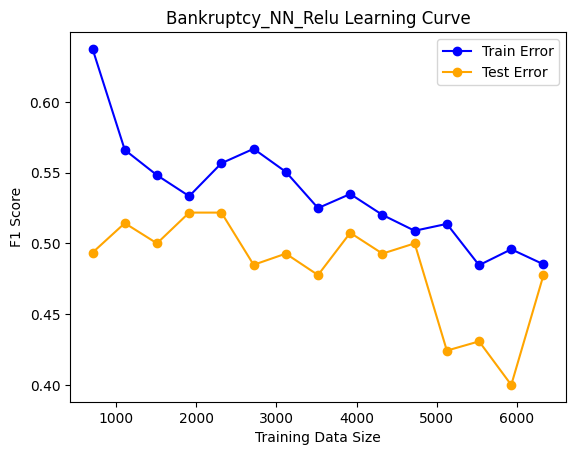

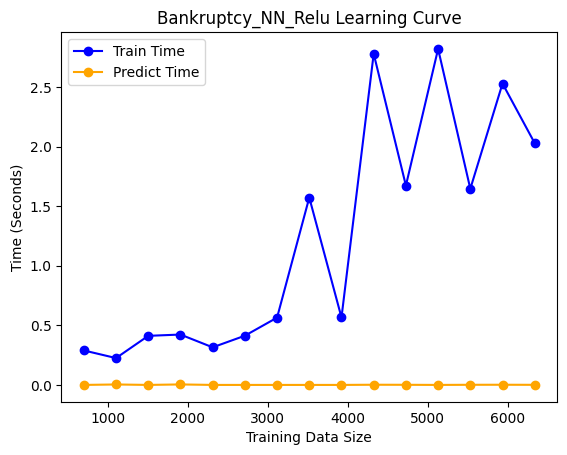

Best Model: {'fit_time': 0.6062095959981283, 'score_time': 0.004958232243855794, 'test_score': 0.7754764638346728, 'train_score': 0.777540391307857, 'index': 4, 'params': {'activation': 'logistic', 'alpha': 1e-06, 'hidden_layer_sizes': [12, 12, 12], 'solver': 'adam'}, 'holdout_score': 0.11289037943501475}


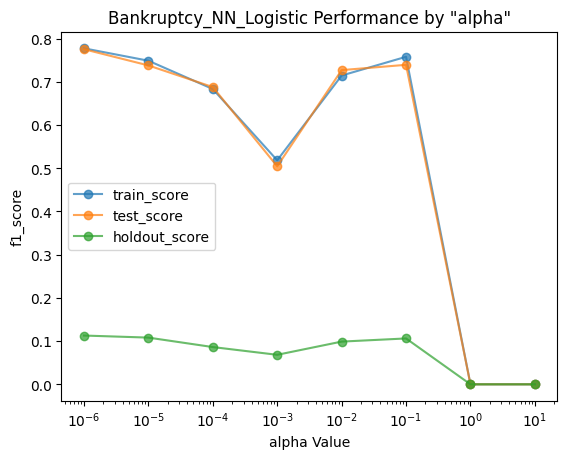

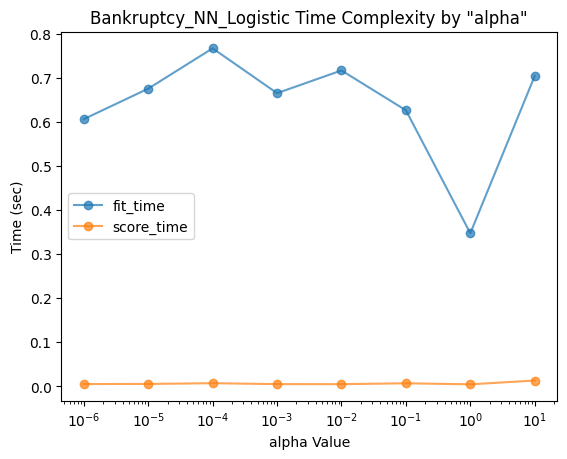

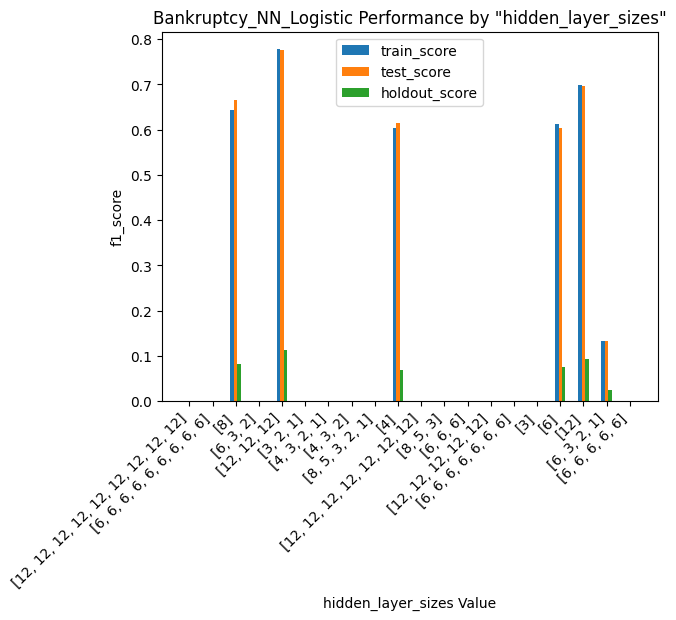

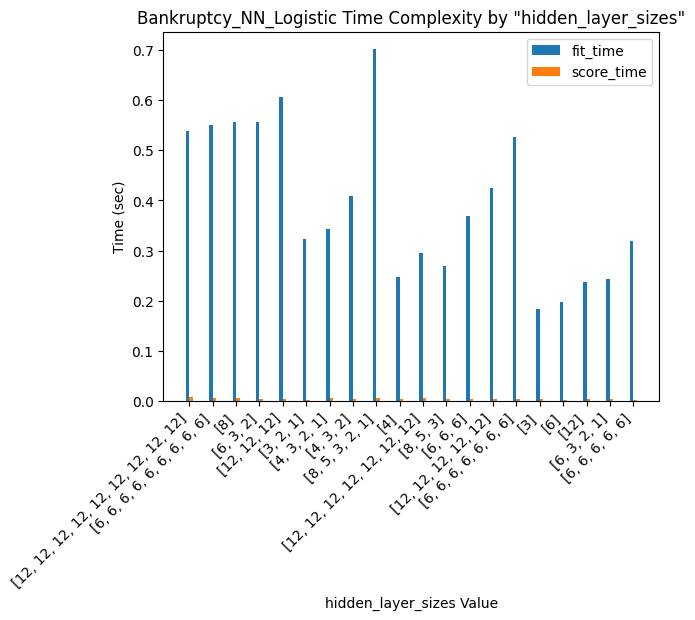

100%|██████████| 15/15 [00:38<00:00,  2.59s/it]


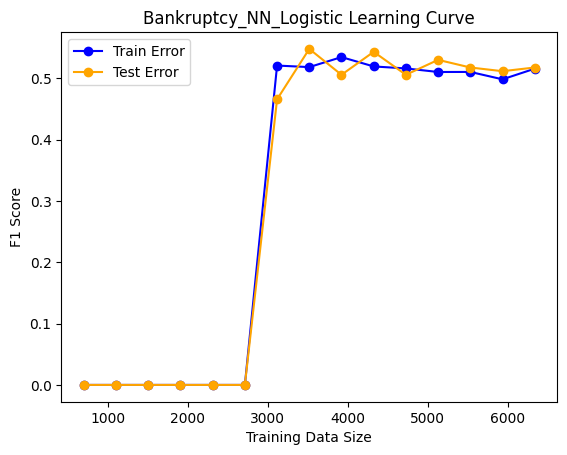

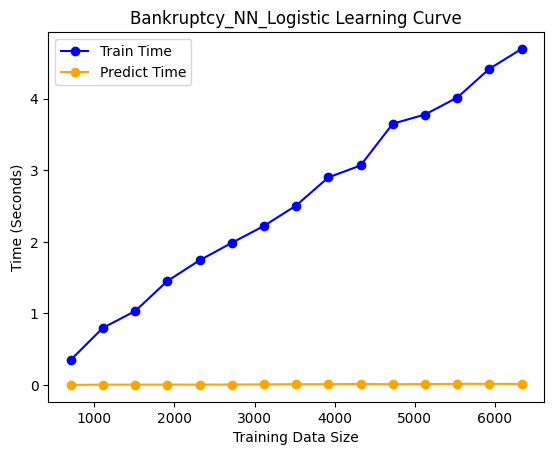

In [ ]:
###############################################
# relu nn - more like delulu amirite
###############################################

n_hidden_layers = range(1, 10, 2)  # 1-9, odds
layer_size_changes = [1, 2/3, 1/2]
hidden_layer_sizes = depth_and_width_to_layer_sizes(n_hidden_layers, layer_size_changes, [financial_train.shape[1], financial_train.shape[1]*2])

bankruptcy_relu_grid = {
    'activation': 'relu',
    'solver': 'adam',
    'alpha': np.logspace(-4, 1, base=10, num=6),
    'hidden_layer_sizes': hidden_layer_sizes,
    'max_iter': range(200, 1001, 100)
}

bankruptcy_relu_expr = {
    'rangedict': bankruptcy_relu_grid,
    'estimator': MLPClassifier,
    'metric': 'f1',
    'X': financial_train,
    'y': bankrupt_train,
    'holdout_X': financial_test,
    'holdout_y': bankrupt_test,
    'holdout_metric': f1_score,
    'want_low': False
}

optimize_and_log(bankruptcy_relu_expr, 'Bankruptcy_NN_Relu.json')
data_size_metrics(
    MLPClassifier, 
    f1_score, 
    pd.concat([financial_train, financial_test]).sample(frac=1, random_state=7), 
    pd.concat([bankrupt_train, bankrupt_test]).sample(frac=1, random_state=7), 
    'Bankruptcy_NN_Relu.json', 
    stratify=True, 
    want_low=False
)

###############################################
# logistic nn
###############################################

bankruptcy_logistic_grid = {
    'activation': 'logistic',
    'solver': 'adam',
    'alpha': np.logspace(-6, 1, base=10, num=8),
    'hidden_layer_sizes': hidden_layer_sizes
}

bankruptcy_logistic_expr = {
    'rangedict': bankruptcy_logistic_grid,
    'estimator': MLPClassifier,
    'metric': 'f1',
    'X': financial_train,
    'y': bankrupt_train,
    'holdout_X': financial_test,
    'holdout_y': bankrupt_test,
    'holdout_metric': f1_score,
    'want_low': False
}

optimize_and_log(bankruptcy_logistic_expr, 'Bankruptcy_NN_Logistic.json')
data_size_metrics(
    MLPClassifier, 
    f1_score, 
    pd.concat([financial_train, financial_test]).sample(frac=1, random_state=7), 
    pd.concat([bankrupt_train, bankrupt_test]).sample(frac=1, random_state=7), 
    'Bankruptcy_NN_Logistic.json', 
    stratify=True, 
    want_low=False
)